# Notes for Circle:
https://stackoverflow.com/questions/491738/how-do-you-calculate-the-average-of-a-set-of-circular-data


In [98]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Exploratory stuff from 2nd half of September

## Plot max expression angles for all genes

## Get angles for each time course point

## Scale each micro-array value with GTEX median tpm, for now, whole blood

## Decide on phase separation on the circle - visual for now

## Export micro-array data as single-cell dataset to classify with Seurat - see if have some coherence

In [2]:
# Read in the GTex Data pick tissue to use for normalization
#gtex paper: cite? https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4010069/
# https://gtexportal.org/home/datasets
# This file contains the median TPM by tissue. These medians were calculated directly from the file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz.
# wget https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz
# for now, picking whole blood
import pandas as pd
tpm_df = pd.read_csv("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t')
gene_name_to_tpm_dict = dict()
for index, row in tpm_df.iterrows():
    gene_name_to_tpm_dict[row["Description"]] = row["Whole Blood"]


In [25]:
# Read in the micro-array data - so far only founds matches between 1230 genes in whitfield in the 56K genes from GTEX
# TODO - get better name mapping
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")

gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
names_for_all_time_courses_list = list()
gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    time_course_1_angles_list.append(((i/17.65)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    time_course_2_angles_list.append(((i/18.6)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    time_course_3_angles_list.append(((i/18)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    time_course_4_angles_list.append(((i/23.95)*2*math.pi + 2.3)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t4_" + str(i))
    
for index, row in whitfield_micro_array_df.iterrows():
    count +=1
    name = str(row['NAME'])
    if (name != 'nan'):
        #print("___" + name + "___")
        names = name.split("^")
        if (len(names) > 1):
            #print("___" + names[1] + "___")
            gene_name = names[1].strip()
            if (gene_name in gene_name_to_tpm_dict and not(gene_name in gene_names_with_micro_array_data)):
                
                
                ####!!!! cut-off to have just a few top cycling genes
                scaled_fourier_score = float(row['Scaled Fourier'])
                #if (scaled_fourier_score < 10.0):
                 #   continue
                tpm = gene_name_to_tpm_dict[gene_name]
                #print(gene_name + " is found")
                gene_names_with_micro_array_data.append(gene_name)
                count_found += 1
                gene_name_to_time_course_expressions_dict[gene_name] = dict()
                gene_name_to_time_course_expressions_dict[gene_name]["one"] = list()
                
                
                new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[11:31] = new_row
            
                new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[32:56] = new_row
                
                new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[57:81] = new_row
                
                new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[82:105] = new_row
                
                
                #TODO: for now adding zero to missing time courses and samples - valid for all things?
                
                for i in range(11,31):
                    gene_name_to_time_course_expressions_dict[gene_name]["one"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["two"] = list()
                for i in range(32,56):
                    gene_name_to_time_course_expressions_dict[gene_name]["two"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["three"] = list()
                for i in range(57,81):
                    gene_name_to_time_course_expressions_dict[gene_name]["three"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["four"] = list()
                for i in range(82,105):
                    gene_name_to_time_course_expressions_dict[gene_name]["four"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
    
                gene_name_to_time_course_expressions_dict[gene_name]["sine"] = row['Sin']
                gene_name_to_time_course_expressions_dict[gene_name]["cosine"] = row['Cos']
                gene_name_to_time_course_expressions_dict[gene_name]["phase"] = row['Phase'].strip()
print(count_found)
#print(gene_name_to_time_course_expressions_dict['KLF6'])

#print(gene_name_to_time_course_expressions_dict["PITPNC1"])

1230


In [31]:
## make micro-array dataframe for seurat's input
import csv
count = 0
whitfield_subset_micro_array_df = pd.DataFrame(columns = names_for_all_time_courses_list)
for gene_name in gene_names_with_micro_array_data:
    count += 1
    whitfield_subset_micro_array_df.loc[gene_name] = gene_name_to_time_course_expressions_dict[gene_name]["one"] + gene_name_to_time_course_expressions_dict[gene_name]["two"] + gene_name_to_time_course_expressions_dict[gene_name]["three"] + gene_name_to_time_course_expressions_dict[gene_name]["four"]
print(count)
whitfield_subset_micro_array_df.to_csv("whitfield_micro_array_as_sc.csv", sep='\t', index=True)

1230


In [53]:
## read in the Seurat phase assignments 

angles_list = time_course_1_angles_list + time_course_2_angles_list + time_course_3_angles_list + time_course_4_angles_list

whitfield_seurat_df = pd.read_csv("whitfield_micro_seurat_labels.csv", sep=',')
whitfield_seurat_phase_list = list()
for index, row in whitfield_seurat_df.iterrows():
    whitfield_seurat_phase_list.append(row["Phase"])
    
whitfield_seurat_df = pd.read_csv("whitfield_micro_seurat_labels_short_list.csv", sep=',')
whitfield_seurat_short_list_phase_list = list()
for index, row in whitfield_seurat_df.iterrows():
    whitfield_seurat_short_list_phase_list.append(row["Phase"])
    

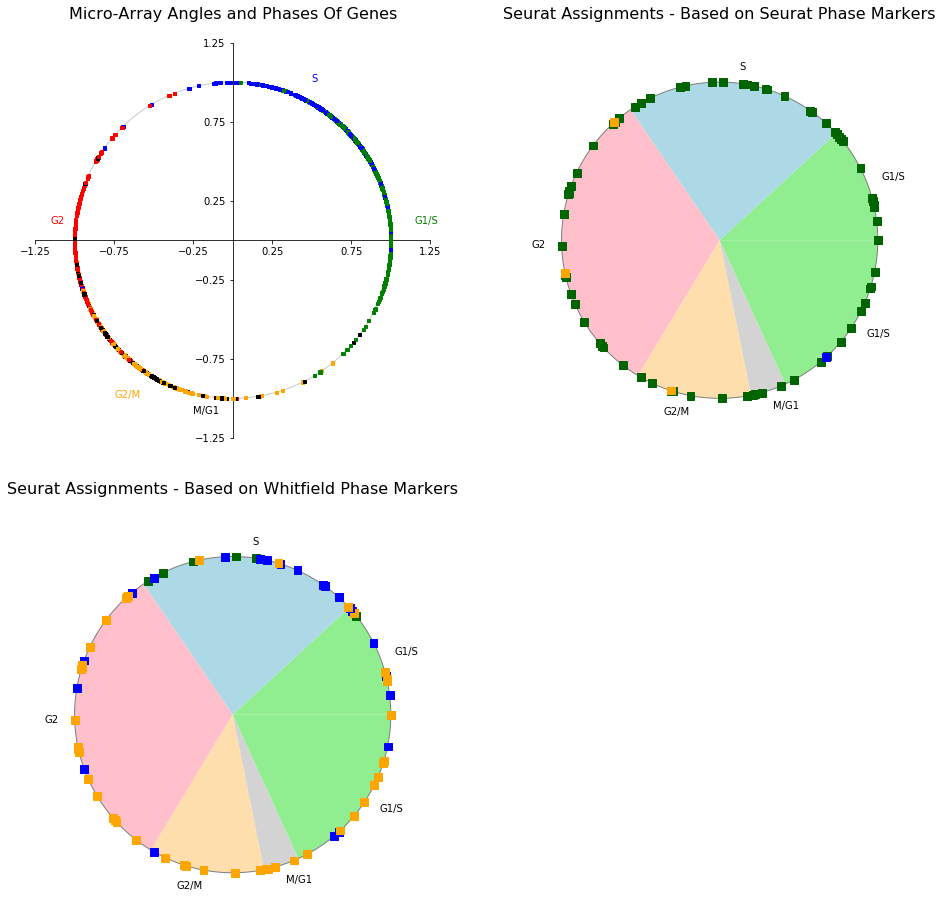

In [55]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(16,16))


#### All Genes
ax=subplot(221, aspect='equal')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))
ax.yaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))

#plot one circle (the biggest one on bottom-right)
# now make a circle with no fill, which is good for hi-lighting key results
circle = Circle((0, 0), 1.0, color='#C1CDCD', fill=False)
ax.add_artist(circle)
#circles(1, 0, 0.5, 'r', alpha=0.2, lw=5, edgecolor='b', transform=ax.transAxes)

#plot a set of circles (circles in diagonal)
#a=arange(11)
#out = circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

# Create a Rectangle patches
for gene_name in gene_names_with_micro_array_data:
    use_color = 'gray'
    if (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G1/S'):
        use_color = 'green'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'S'):
        use_color = 'blue'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2'):
        use_color = 'red'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2/M'):
        use_color = 'orange'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'M/G1'):
        use_color = 'black'
    rect = Rectangle((gene_name_to_time_course_expressions_dict[gene_name]["cosine"]-0.01,gene_name_to_time_course_expressions_dict[gene_name]["sine"]-0.01),0.02,0.02,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=9)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
text(1.15, 0.1, "G1/S", color='green')
text(0.5, 1, "S", color='blue')
text(-1.15, 0.1, "G2", color='red')
text(-0.75, -1, "G2/M", color='orange')
text(-0.25, -1.1, "M/G1", color='black')

title("Micro-Array Angles and Phases Of Genes\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(222, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (whitfield_seurat_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (whitfield_seurat_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - Based on Seurat Phase Markers\n", fontsize=16)

# Phase segmentation on the circle
ax=subplot(223, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (whitfield_seurat_short_list_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_short_list_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (whitfield_seurat_short_list_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - Based on Whitfield Phase Markers\n", fontsize=16)

xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()


# Seurat Assignments for Our Human MicroArray, By Individual Time Courses

## Try To See if Seurat Can Properly Quantify the Stahlberg Single Cell Data

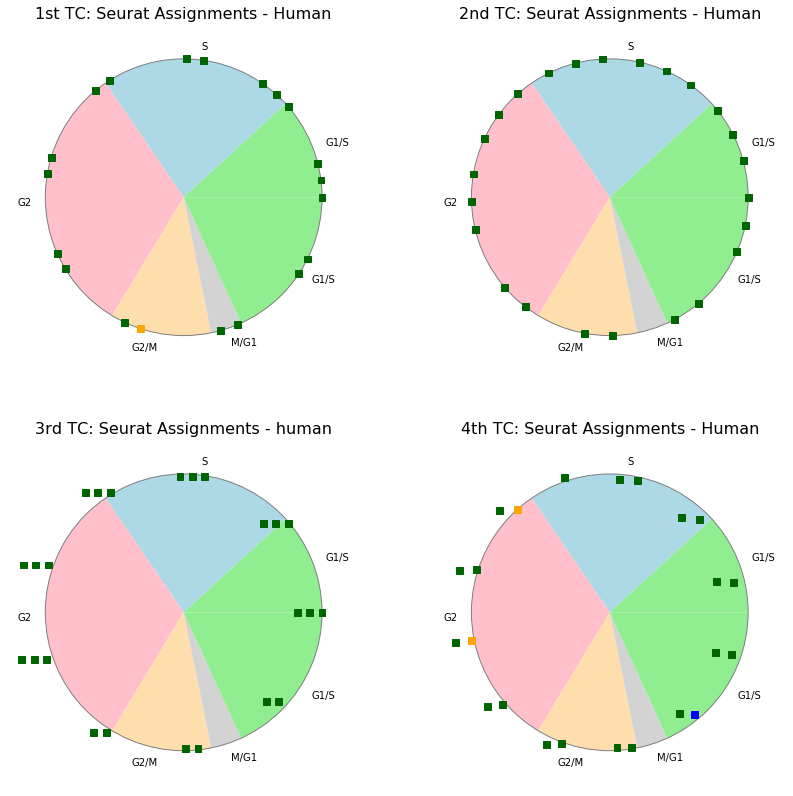

In [189]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(14,14))



##########
# Phase segmentation on the circle
ax=subplot(221, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,20):
    use_color = 'gray'
    if (whitfield_seurat_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (whitfield_seurat_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 8
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("1st TC: Seurat Assignments - Human", fontsize=16)


##########
# Phase segmentation on the circle
ax=subplot(222, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(20,44):
    use_color = 'gray'
    if (whitfield_seurat_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (whitfield_seurat_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("2nd TC: Seurat Assignments - Human", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(223, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(44,68):
    use_color = 'gray'
    offset = (i-44) * 0.01
    if (whitfield_seurat_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (whitfield_seurat_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025-offset,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("3rd TC: Seurat Assignments - human", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(224, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(68,91):
    use_color = 'gray'
    offset = (i-68) * 0.01
    if (whitfield_seurat_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (whitfield_seurat_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025-offset,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("4th TC: Seurat Assignments - Human", fontsize=16)


xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()

In [186]:
### process Stahlberg single cell data for Seurat input
stahlberg_MCF7_df = pd.read_csv("Stahlberg_MCF7_group_1_to_6.csv", sep=',')
def phase_to_string(phase_number):
    if (phase_number in (1, 4, 9)):
        return "G1"
    if (phase_number in (2, 5, 10)):
        return "S"
    if (phase_number in (3, 6, 11)):
        return "G2"
stahlberg_MCF7_df = stahlberg_MCF7_df.rename(lambda x: x + "_" + phase_to_string(int(stahlberg_MCF7_df.loc[x, "#Group"])))
stahlberg_MCF7_df = stahlberg_MCF7_df.iloc[:,:-3]
stahlberg_MCF7_df = stahlberg_MCF7_df.replace(-1,0.0).T
#print(stahlberg_MCF7_df)

seurat_genes = [line.rstrip('\n') for line in open('regev_lab_cell_cycle_genes.txt')]
seurat_intersect_genes = list()
for gene in seurat_genes:
    if gene in stahlberg_MCF7_df.index:
        seurat_intersect_genes.append(gene)
        
stahlberg_MCF7_seurat_df = stahlberg_MCF7_df.loc[seurat_intersect_genes]
stahlberg_MCF7_no_seurat_df = stahlberg_MCF7_df.drop(stahlberg_MCF7_seurat_df.index)
#print(stahlberg_MCF7_no_seurat_df)

dfs = dict()
dfs["orig"] = stahlberg_MCF7_df
for i in range(0, 29):
    name = "df_" + str(i)
    dfs[name] = stahlberg_MCF7_no_seurat_df.rename(lambda x: x + "_" + str(i))
expanded_stahlberg_MCF7_df = pd.concat(dfs.values())
#print(expanded_stahlberg_MCF7_df)
expanded_stahlberg_MCF7_df.to_csv("expanded_stahlberg_MCF7_as_sc.csv", sep='\t', index=True)

In [270]:

stahlberg_seurat_df = pd.read_csv("stahlberg_seurat_labels.csv", sep=',')

S_tp = 0
S_fp = 0
S_fn = 0
G2M_tp = 0
G2M_fp = 0
G2M_fn = 0
G1_tp = 0
G1_fp = 0
G1_fn = 0

all_count = 0
correct_count = 0
for index, row in stahlberg_seurat_df.iterrows():
    all_count += 1
    if ("_G1" in row[0] and row["Phase"] == "G1"):
        correct_count += 1
    if ("_S" in row[0] and row["Phase"] == "S"):
        correct_count += 1  
    if ("_G2" in row[0] and row["Phase"] == "G2M"):
        correct_count += 1
    
    if ("_S" in row[0]):
        if (row["Phase"] == "S"):
            S_tp += 1
        else:
            S_fn += 1
            if (row["Phase"] == "G2M"):
                G2M_fp += 1
            elif (row["Phase"] == "G1"):
                G1_fp += 1
    elif ("_G2" in row[0]):
        if (row["Phase"] == "G2M"):
            G2M_tp += 1
        else:
            G2M_fn += 1
            if (row["Phase"] == "S"):
                S_fp += 1
            elif (row["Phase"] == "G1"):
                G1_fp += 1
    elif ("_G1" in row[0]):
        if (row["Phase"] == "G1"):
            G1_tp += 1
        else:
            G1_fn += 1
            if (row["Phase"] == "S"):
                S_fp += 1
            elif (row["Phase"] == "G2M"):
                G2M_fp += 1 

print("Correct Count out of 91")
print(correct_count)
print("Percent Accuracy")
print(correct_count/all_count)

S_precision = S_tp / (S_tp + S_fp) if S_tp else 0
S_recall = S_tp / (S_tp + S_fn) if S_tp else 0
G2M_precision = G2M_tp / (G2M_tp + G2M_fp) if G2M_tp else 0
G2M_recall = G2M_tp / (G2M_tp + G2M_fn) if G2M_tp else 0
G1_precision = G1_tp / (G1_tp + G1_fp) if G1_tp else 0
G1_recall = G1_tp / (G1_tp + G1_fn) if G1_tp else 0
precision_avg = (S_precision + G2M_precision + G1_precision)/3
recall_avg = (S_recall + G2M_recall + G1_recall)/3
f1_score = 2*((precision_avg*recall_avg)/(precision_avg+recall_avg))
print("F1_score")
print(f1_score)

Correct Count out of 91
51
Percent Accuracy
0.5666666666666667
F1_score
0.5838824120039116


# Try to get a different dataset to work with Seurat:
# scale the micro-array with mouse hameopotetic progenitor cells TPM values,
# add this to the Nesterova Dataset to augment it (using intersecting gene set)
# read in the assignments to just our micro-array points by Seurat...
# if fails, check again how Seurat does picking - is it really col-normalized???

In [142]:
# Download EMBL Expression Atlas Data, and get TPMP for progenitor cells
# https://www.ebi.ac.uk/gxa/experiments/E-MTAB-3079/Downloads
# EMBL_Murine_Hematopoietic_progenitors_TPMS.tsv

mouse_tpm_df = pd.read_csv("EMBL_Murine_Hematopoietic_progenitors_TPMS.tsv", sep='\t')
mouse_gene_name_to_tpm_dict = dict()
for index, row in mouse_tpm_df.iterrows():
    tpm =  row["Kit and Sca1-positive hematopoietic stem cell"]
    if (str(tpm) != "nan"):
        mouse_gene_name_to_tpm_dict[row["Gene Name"].upper()]  = tpm

In [185]:
#print(mouse_gene_name_to_tpm_dict["HSPA1A"])

In [144]:
# Read in the micro-array data - get matches between in whitfield and EMBL mouse genes
# TODO - get better name mapping
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")

mouse_gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
mouse_names_for_all_time_courses_list = list()
mouse_gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    time_course_1_angles_list.append(((i/17.65)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    time_course_2_angles_list.append(((i/18.6)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    time_course_3_angles_list.append(((i/18)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    time_course_4_angles_list.append(((i/23.95)*2*math.pi + 2.3)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t4_" + str(i))
    
for index, row in whitfield_micro_array_df.iterrows():
    count +=1
    name = str(row['NAME'])
    if (name != 'nan'):
        #print("___" + name + "___")
        names = name.split("^")
        if (len(names) > 1):
            #print("___" + names[1] + "___")
            gene_name = names[1].strip()
            if (gene_name in mouse_gene_name_to_tpm_dict and not(gene_name in mouse_gene_names_with_micro_array_data)):
                
                
                ####!!!! cut-off to have just a few top cycling genes
                scaled_fourier_score = float(row['Scaled Fourier'])
                #if (scaled_fourier_score < 10.0):
                 #   continue
                tpm = mouse_gene_name_to_tpm_dict[gene_name]
                #print(gene_name + " is found")
                mouse_gene_names_with_micro_array_data.append(gene_name)
                count_found += 1
                mouse_gene_name_to_time_course_expressions_dict[gene_name] = dict()
                
                new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[11:31] = new_row
            
                new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[32:56] = new_row
                
                new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[57:81] = new_row
                
                new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[82:105] = new_row
                
                
                #TODO: for now adding zero to missing time courses and samples - valid for all things?
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["one"] = list()
                for i in range(11,31):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["one"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["two"] = list()
                for i in range(32,56):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["two"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["three"] = list()
                for i in range(57,81):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["three"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["four"] = list()
                for i in range(82,105):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["four"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
    
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["sine"] = row['Sin']
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["cosine"] = row['Cos']
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["phase"] = row['Phase'].strip()
                
                if (gene_name == "HSPA1A"):
                    print(mouse_gene_name_to_time_course_expressions_dict[gene_name])
                    print("_" + str(tpm) + "_")
print(count_found)

1002


In [145]:
print(len(mouse_gene_names_with_micro_array_data))
nesterova_df = pd.read_table("nestorawa_forcellcycle_expressionMatrix.txt", index_col = 0)
nesterova_gene_names = nesterova_df.index.values

1002


In [146]:
common_mouse_microarray_and_nesterova_genes = list()
for gene_name in mouse_gene_names_with_micro_array_data:
    if (gene_name in nesterova_gene_names):
        common_mouse_microarray_and_nesterova_genes.append(gene_name)
print(len(common_mouse_microarray_and_nesterova_genes))

1000


In [163]:
# make a common dataset for the intersection
nesterova_mouse_subset_df = nesterova_df.loc[common_mouse_microarray_and_nesterova_genes]
whitfield_mouse_micro_array_df = pd.DataFrame(columns = mouse_names_for_all_time_courses_list)
for gene_name in common_mouse_microarray_and_nesterova_genes:
    whitfield_mouse_micro_array_df.loc[gene_name] = mouse_gene_name_to_time_course_expressions_dict[gene_name]["one"] + mouse_gene_name_to_time_course_expressions_dict[gene_name]["two"] + mouse_gene_name_to_time_course_expressions_dict[gene_name]["three"] + mouse_gene_name_to_time_course_expressions_dict[gene_name]["four"]
nesterova_plus_micro_array_df = pd.concat([nesterova_mouse_subset_df, whitfield_mouse_micro_array_df], axis=1)
nesterova_plus_micro_array_df.to_csv("nesterova_plus_micro_array_df.csv", sep='\t', index=True)
whitfield_mouse_micro_array_df.to_csv("mouse_only_micro_array_df.csv", sep='\t', index=True)

In [164]:
## read in the Seurat phase assignments 

angles_list = time_course_1_angles_list + time_course_2_angles_list + time_course_3_angles_list + time_course_4_angles_list

nesterova_plus_micro_array_labels_df = pd.read_csv("nesterova_plus_micro_array_labels.csv", sep=',')
nesterova_plus_micro_array_phase_list = list()
for index, row in nesterova_plus_micro_array_labels_df.iterrows():
    if (row[0].startswith("t")):
        nesterova_plus_micro_array_phase_list.append(row["Phase"])
        
mouse_only_micro_array_labels_df = pd.read_csv("mouse_only_micro_array_labels.csv", sep=',')
mouse_only_micro_array_phase_list = list()
for index, row in mouse_only_micro_array_labels_df.iterrows():
    if (row[0].startswith("t")):
        mouse_only_micro_array_phase_list.append(row["Phase"])

In [184]:
#print(time_course_3_angles_list)
#for i in range(44,68):
 #   print(nesterova_plus_micro_array_phase_list[i] + "___" + str(angles_list[i]))

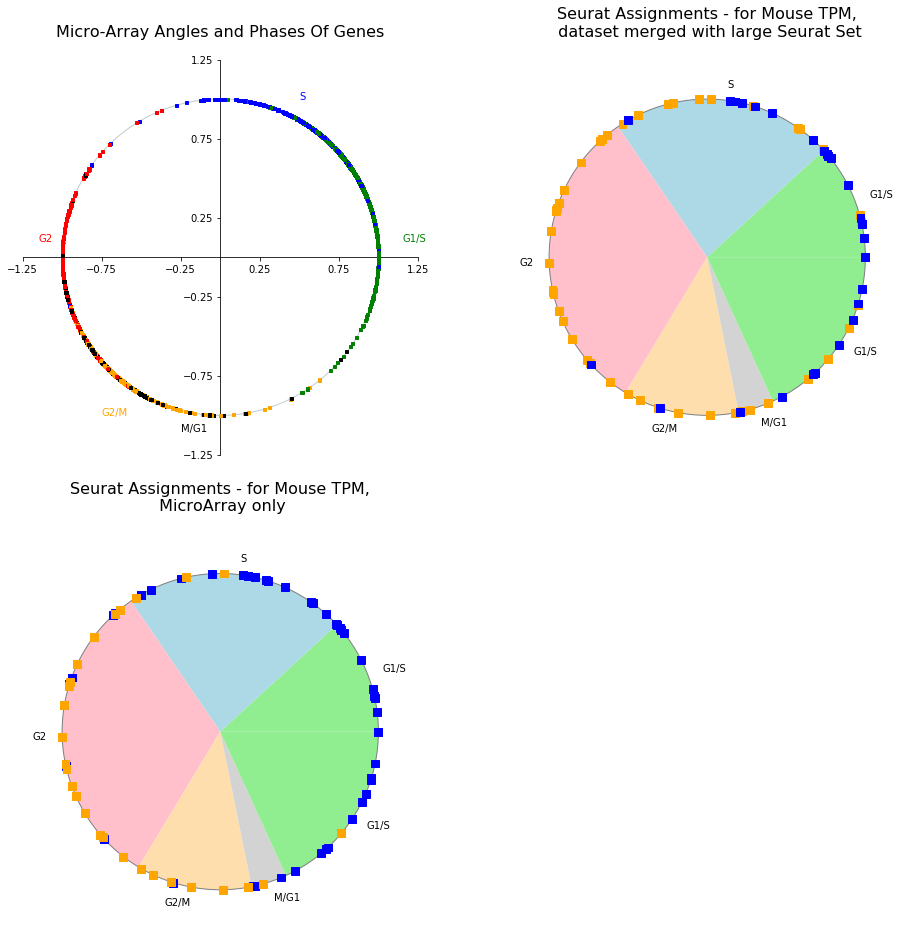

In [168]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(16,16))


#### All Genes
ax=subplot(221, aspect='equal')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))
ax.yaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))

#plot one circle (the biggest one on bottom-right)
# now make a circle with no fill, which is good for hi-lighting key results
circle = Circle((0, 0), 1.0, color='#C1CDCD', fill=False)
ax.add_artist(circle)
#circles(1, 0, 0.5, 'r', alpha=0.2, lw=5, edgecolor='b', transform=ax.transAxes)

#plot a set of circles (circles in diagonal)
#a=arange(11)
#out = circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

# Create a Rectangle patches
for gene_name in gene_names_with_micro_array_data:
    use_color = 'gray'
    if (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G1/S'):
        use_color = 'green'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'S'):
        use_color = 'blue'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2'):
        use_color = 'red'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2/M'):
        use_color = 'orange'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'M/G1'):
        use_color = 'black'
    rect = Rectangle((gene_name_to_time_course_expressions_dict[gene_name]["cosine"]-0.01,gene_name_to_time_course_expressions_dict[gene_name]["sine"]-0.01),0.02,0.02,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=9)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
text(1.15, 0.1, "G1/S", color='green')
text(0.5, 1, "S", color='blue')
text(-1.15, 0.1, "G2", color='red')
text(-0.75, -1, "G2/M", color='orange')
text(-0.25, -1.1, "M/G1", color='black')

title("Micro-Array Angles and Phases Of Genes\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(222, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (nesterova_plus_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (nesterova_plus_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (nesterova_plus_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 8
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - for Mouse TPM,\n dataset merged with large Seurat Set\n", fontsize=16)


##########
# Phase segmentation on the circle
ax=subplot(223, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (mouse_only_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (mouse_only_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (mouse_only_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - for Mouse TPM,\n MicroArray only\n", fontsize=16)


xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()

# Seurat Assignments - for Mouse TPM  Merged With Large Nesterova Set

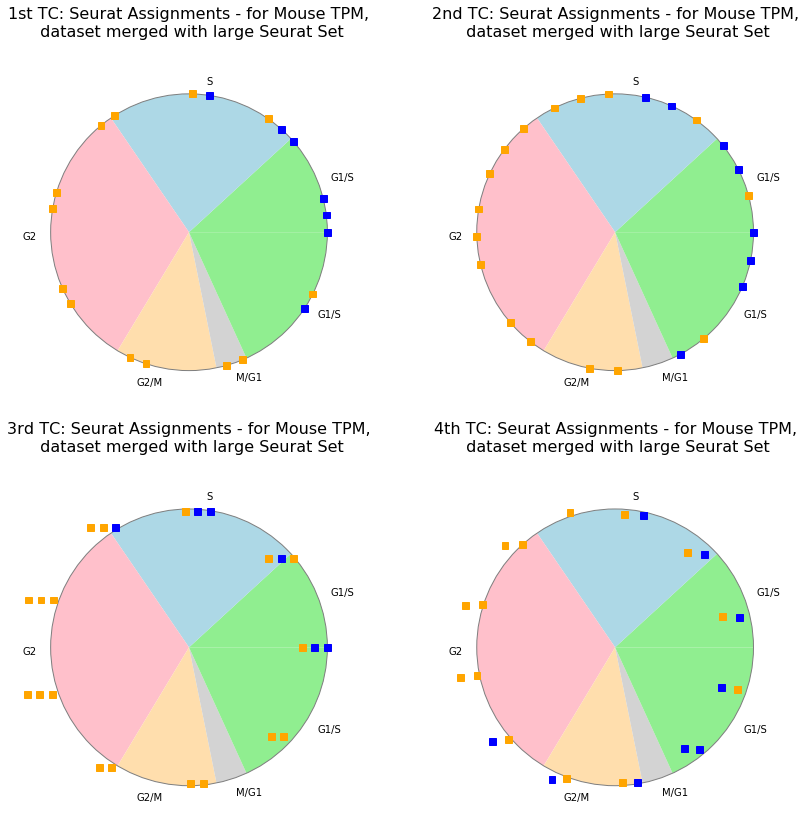

In [180]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(14,14))



##########
# Phase segmentation on the circle
ax=subplot(221, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,20):
    use_color = 'gray'
    if (nesterova_plus_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (nesterova_plus_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (nesterova_plus_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 8
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("1st TC: Seurat Assignments - for Mouse TPM,\n dataset merged with large Seurat Set\n", fontsize=16)


##########
# Phase segmentation on the circle
ax=subplot(222, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(20,44):
    use_color = 'gray'
    if (nesterova_plus_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (nesterova_plus_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (nesterova_plus_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("2nd TC: Seurat Assignments - for Mouse TPM,\n dataset merged with large Seurat Set\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(223, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(44,68):
    use_color = 'gray'
    offset = (i-44) * 0.01
    if (nesterova_plus_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (nesterova_plus_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (nesterova_plus_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025-offset,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("3rd TC: Seurat Assignments - for Mouse TPM,\n dataset merged with large Seurat Set\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(224, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(68,91):
    use_color = 'gray'
    offset = (i-68) * 0.01
    if (nesterova_plus_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (nesterova_plus_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (nesterova_plus_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025-offset,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("4th TC: Seurat Assignments - for Mouse TPM,\n dataset merged with large Seurat Set\n", fontsize=16)


xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()

# Seurat Assignments - for Mouse TPM  MicroArray only

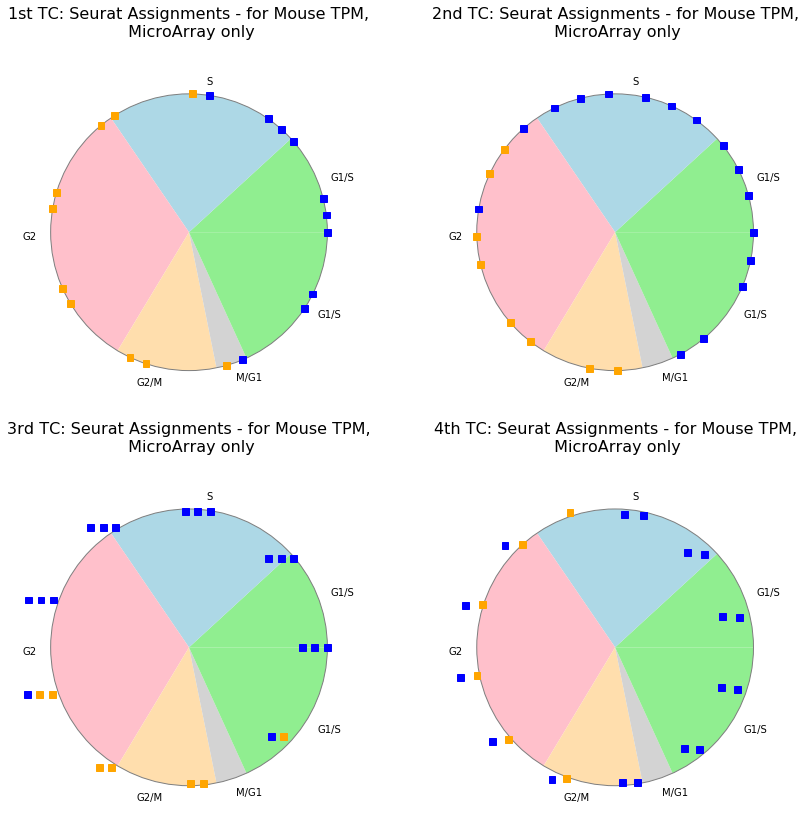

In [188]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(14,14))



##########
# Phase segmentation on the circle
ax=subplot(221, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,20):
    use_color = 'gray'
    if (mouse_only_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (mouse_only_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (mouse_only_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 8
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("1st TC: Seurat Assignments - for Mouse TPM,\n MicroArray only\n", fontsize=16)


##########
# Phase segmentation on the circle
ax=subplot(222, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(20,44):
    use_color = 'gray'
    if (mouse_only_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (mouse_only_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (mouse_only_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("2nd TC: Seurat Assignments - for Mouse TPM,\n MicroArray only\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(223, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(44,68):
    use_color = 'gray'
    offset = (i-44) * 0.01
    if (mouse_only_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (mouse_only_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (mouse_only_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025-offset,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("3rd TC: Seurat Assignments - for Mouse TPM,\n MicroArray only\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(224, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(68,91):
    use_color = 'gray'
    offset = (i-68) * 0.01
    if (mouse_only_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (mouse_only_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 8
    elif (mouse_only_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025-offset,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("4th TC: Seurat Assignments - for Mouse TPM,\n MicroArray only\n", fontsize=16)


xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()

# Assess which human tissue TPM gives best Seurat assignment


In [198]:
import pandas as pd
tpm_df = pd.read_csv("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t')
tissue_gene_name_to_tpm_dict = dict()
for index, row in tpm_df.iterrows():
    for t_id in range(2,55):
        tissue = tpm_df.columns[t_id].replace(" ", "")
        if tissue not in tissue_gene_name_to_tpm_dict:
            tissue_gene_name_to_tpm_dict[tissue] = dict()
        tissue_gene_name_to_tpm_dict[tissue][row["Description"]] = row[t_id]
        #print(tissue + " " + str(row[t_id]))

In [212]:
%%time
# Read in the micro-array data - so far only founds matches between 1230 genes in whitfield in the 56K genes from GTEX
# TODO - get better name mapping
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
names_for_all_time_courses_list = list()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    time_course_1_angles_list.append(((i/17.65)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    time_course_2_angles_list.append(((i/18.6)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    time_course_3_angles_list.append(((i/18)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    time_course_4_angles_list.append(((i/23.95)*2*math.pi + 2.3)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t4_" + str(i))

tissue_gene_name_to_time_course_expressions_dict = dict()

for tissue in tissue_gene_name_to_tpm_dict:  
    tissue_gene_name_to_time_course_expressions_dict[tissue] = dict()
    
    gene_names_with_micro_array_data = list()
    
    for index, row in whitfield_micro_array_df.iterrows():
        count +=1
        name = str(row['NAME'])
        if (name != 'nan'):
            #print("___" + name + "___")
            names = name.split("^")
            if (len(names) > 1):
                #print("___" + names[1] + "___")
                gene_name = names[1].strip()
                if (gene_name in tissue_gene_name_to_tpm_dict['WholeBlood'] and not(gene_name in gene_names_with_micro_array_data)):


                    ####!!!! cut-off to have just a few top cycling genes
                    scaled_fourier_score = float(row['Scaled Fourier'])
                    #if (scaled_fourier_score < 10.0):
                     #   continue
                    tpm = tissue_gene_name_to_tpm_dict[tissue][gene_name]
                    #print(gene_name + " is found")
                    gene_names_with_micro_array_data.append(gene_name)
                    count_found += 1
                    tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name] = dict()
                    tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["one"] = list()


                    new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                    new_row = new_row.fillna(0)
                    row[11:31] = new_row

                    new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                    new_row = new_row.fillna(0)
                    row[32:56] = new_row

                    new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                    new_row = new_row.fillna(0)
                    row[57:81] = new_row

                    new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                    new_row = new_row.fillna(0)
                    row[82:105] = new_row


                    #TODO: for now adding zero to missing time courses and samples - valid for all things?

                    for i in range(11,31):
                        tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["one"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                    tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["two"] = list()
                    for i in range(32,56):
                        tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["two"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                    tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["three"] = list()
                    for i in range(57,81):
                        tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["three"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                    tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["four"] = list()
                    for i in range(82,105):
                        tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["four"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data


CPU times: user 7min 33s, sys: 1.56 ms, total: 7min 33s
Wall time: 7min 32s


In [213]:
%%time
## make micro-array dataframe for seurat's input
import csv

for tissue in tissue_gene_name_to_tpm_dict:
    print(tissue)
    whitfield_subset_micro_array_df = pd.DataFrame(columns = names_for_all_time_courses_list)
    #print(names_for_all_time_courses_list)
    for gene_name in tissue_gene_name_to_time_course_expressions_dict[tissue]:
        count += 1
        all_time_course_names =  tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["one"] + tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["two"] + tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["three"] + tissue_gene_name_to_time_course_expressions_dict[tissue][gene_name]["four"] 
        #print(all_time_course_names)
        whitfield_subset_micro_array_df.loc[gene_name] = all_time_course_names
    whitfield_subset_micro_array_df.to_csv(tissue + "_" + "whitfield_micro_array_as_sc.csv", sep='\t', index=True)

Adipose-Subcutaneous
Adipose-Visceral(Omentum)
AdrenalGland
Artery-Aorta
Artery-Coronary
Artery-Tibial
Bladder
Brain-Amygdala
Brain-Anteriorcingulatecortex(BA24)
Brain-Caudate(basalganglia)
Brain-CerebellarHemisphere
Brain-Cerebellum
Brain-Cortex
Brain-FrontalCortex(BA9)
Brain-Hippocampus
Brain-Hypothalamus
Brain-Nucleusaccumbens(basalganglia)
Brain-Putamen(basalganglia)
Brain-Spinalcord(cervicalc-1)
Brain-Substantianigra
Breast-MammaryTissue
Cells-EBV-transformedlymphocytes
Cells-Transformedfibroblasts
Cervix-Ectocervix
Cervix-Endocervix
Colon-Sigmoid
Colon-Transverse
Esophagus-GastroesophagealJunction
Esophagus-Mucosa
Esophagus-Muscularis
FallopianTube
Heart-AtrialAppendage
Heart-LeftVentricle
Kidney-Cortex
Liver
Lung
MinorSalivaryGland
Muscle-Skeletal
Nerve-Tibial
Ovary
Pancreas
Pituitary
Prostate
Skin-NotSunExposed(Suprapubic)
Skin-SunExposed(Lowerleg)
SmallIntestine-TerminalIleum
Spleen
Stomach
Testis
Thyroid
Uterus
Vagina
WholeBlood
CPU times: user 2min 30s, sys: 90.2 ms, total: 

In [262]:
whitfield_timepoints_phases = list()
for i in range(0,len(names_for_all_time_courses_list)):
    phase = -1
    if angles_list[i] >= 0 and angles_list[i] <= 2:
        phase = "S"
    elif angles_list[i] > 2 and angles_list[i] <= 4.8:
        phase = "G2M"
    elif angles_list[i] > 4.8 and angles_list[i] <= 5.9:
        phase = "G1"
    elif angles_list[i] > 5.9:
        phase = "S"
    whitfield_timepoints_phases.append(phase)
    #print(names_for_all_time_courses_list[i] + " " + str(angles_list[i]) + " " + phase)

In [263]:

tissue_score_dict = dict()
tissue_data_line_dict = dict()
for tissue in tissue_gene_name_to_tpm_dict:
    #print(tissue)
    labels_file_name = "labels_" + tissue + "_whitfield_micro_array_as_sc.csv";    
    whitfield_seurat_df = pd.read_csv(labels_file_name, sep=',')
    whitfield_seurat_phase_list = list()
    for index, row in whitfield_seurat_df.iterrows():
        whitfield_seurat_phase_list.append(row["Phase"])
    S_tp = 0
    S_fp = 0
    S_fn = 0
    G2M_tp = 0
    G2M_fp = 0
    G2M_fn = 0
    G1_tp = 0
    G1_fp = 0
    G1_fn = 0
    for i in range(0,len(whitfield_seurat_phase_list)):
        #print(whitfield_timepoints_phases[i] + " " + whitfield_seurat_phase_list[i])
        if (whitfield_timepoints_phases[i] == "S"):
            if (whitfield_seurat_phase_list[i] == "S"):
                S_tp += 1
            else:
                S_fn += 1
                if (whitfield_seurat_phase_list[i] == "G2M"):
                    G2M_fp += 1
                elif (whitfield_seurat_phase_list[i] == "G1"):
                    G1_fp += 1
        elif (whitfield_timepoints_phases[i] == "G2M"):
            if (whitfield_seurat_phase_list[i] == "G2M"):
                G2M_tp += 1
            else:
                G2M_fn += 1
                if (whitfield_seurat_phase_list[i] == "S"):
                    S_fp += 1
                elif (whitfield_seurat_phase_list[i] == "G1"):
                    G1_fp += 1
        elif (whitfield_timepoints_phases[i] == "G1"):
            if (whitfield_seurat_phase_list[i] == "G1"):
                G1_tp += 1
            else:
                G1_fn += 1
                if (whitfield_seurat_phase_list[i] == "S"):
                    S_fp += 1
                elif (whitfield_seurat_phase_list[i] == "G2M"):
                    G2M_fp += 1 
    #print("S" + " " + str(S_tp) + " " + str(S_fn) + " " + str(S_fp))
    #print("G2M" + " " + str(G2M_tp) + " " + str(G2M_fn) + " " + str(G2M_fp))
    #print("G1" + " " + str(G1_tp) + " " + str(G1_fn) + " " + str(G1_fp))
    S_precision = S_tp / (S_tp + S_fp) if S_tp else 0
    S_recall = S_tp / (S_tp + S_fn) if S_tp else 0
    G2M_precision = G2M_tp / (G2M_tp + G2M_fp) if G2M_tp else 0
    G2M_recall = G2M_tp / (G2M_tp + G2M_fn) if G2M_tp else 0
    G1_precision = G1_tp / (G1_tp + G1_fp) if G1_tp else 0
    G1_recall = G1_tp / (G1_tp + G1_fn) if G1_tp else 0
    precision_avg = (S_precision + G2M_precision + G1_precision)/3
    recall_avg = (S_recall + G2M_recall + G1_recall)/3
    f1_score = 2*((precision_avg*recall_avg)/(precision_avg+recall_avg))
    tissue_score_dict[tissue] = f1_score
    tissue_data_line_dict[tissue] = [tissue, np.round(float(precision_avg), 2), np.round(float(recall_avg), 2), np.round(float(f1_score), 2)]

    
    

In [264]:
import operator
data = []
sorted_x = sorted(tissue_score_dict.items(), key=operator.itemgetter(1), reverse=True)
for (tissue,value) in sorted_x:
    data.append(tissue_data_line_dict[tissue])

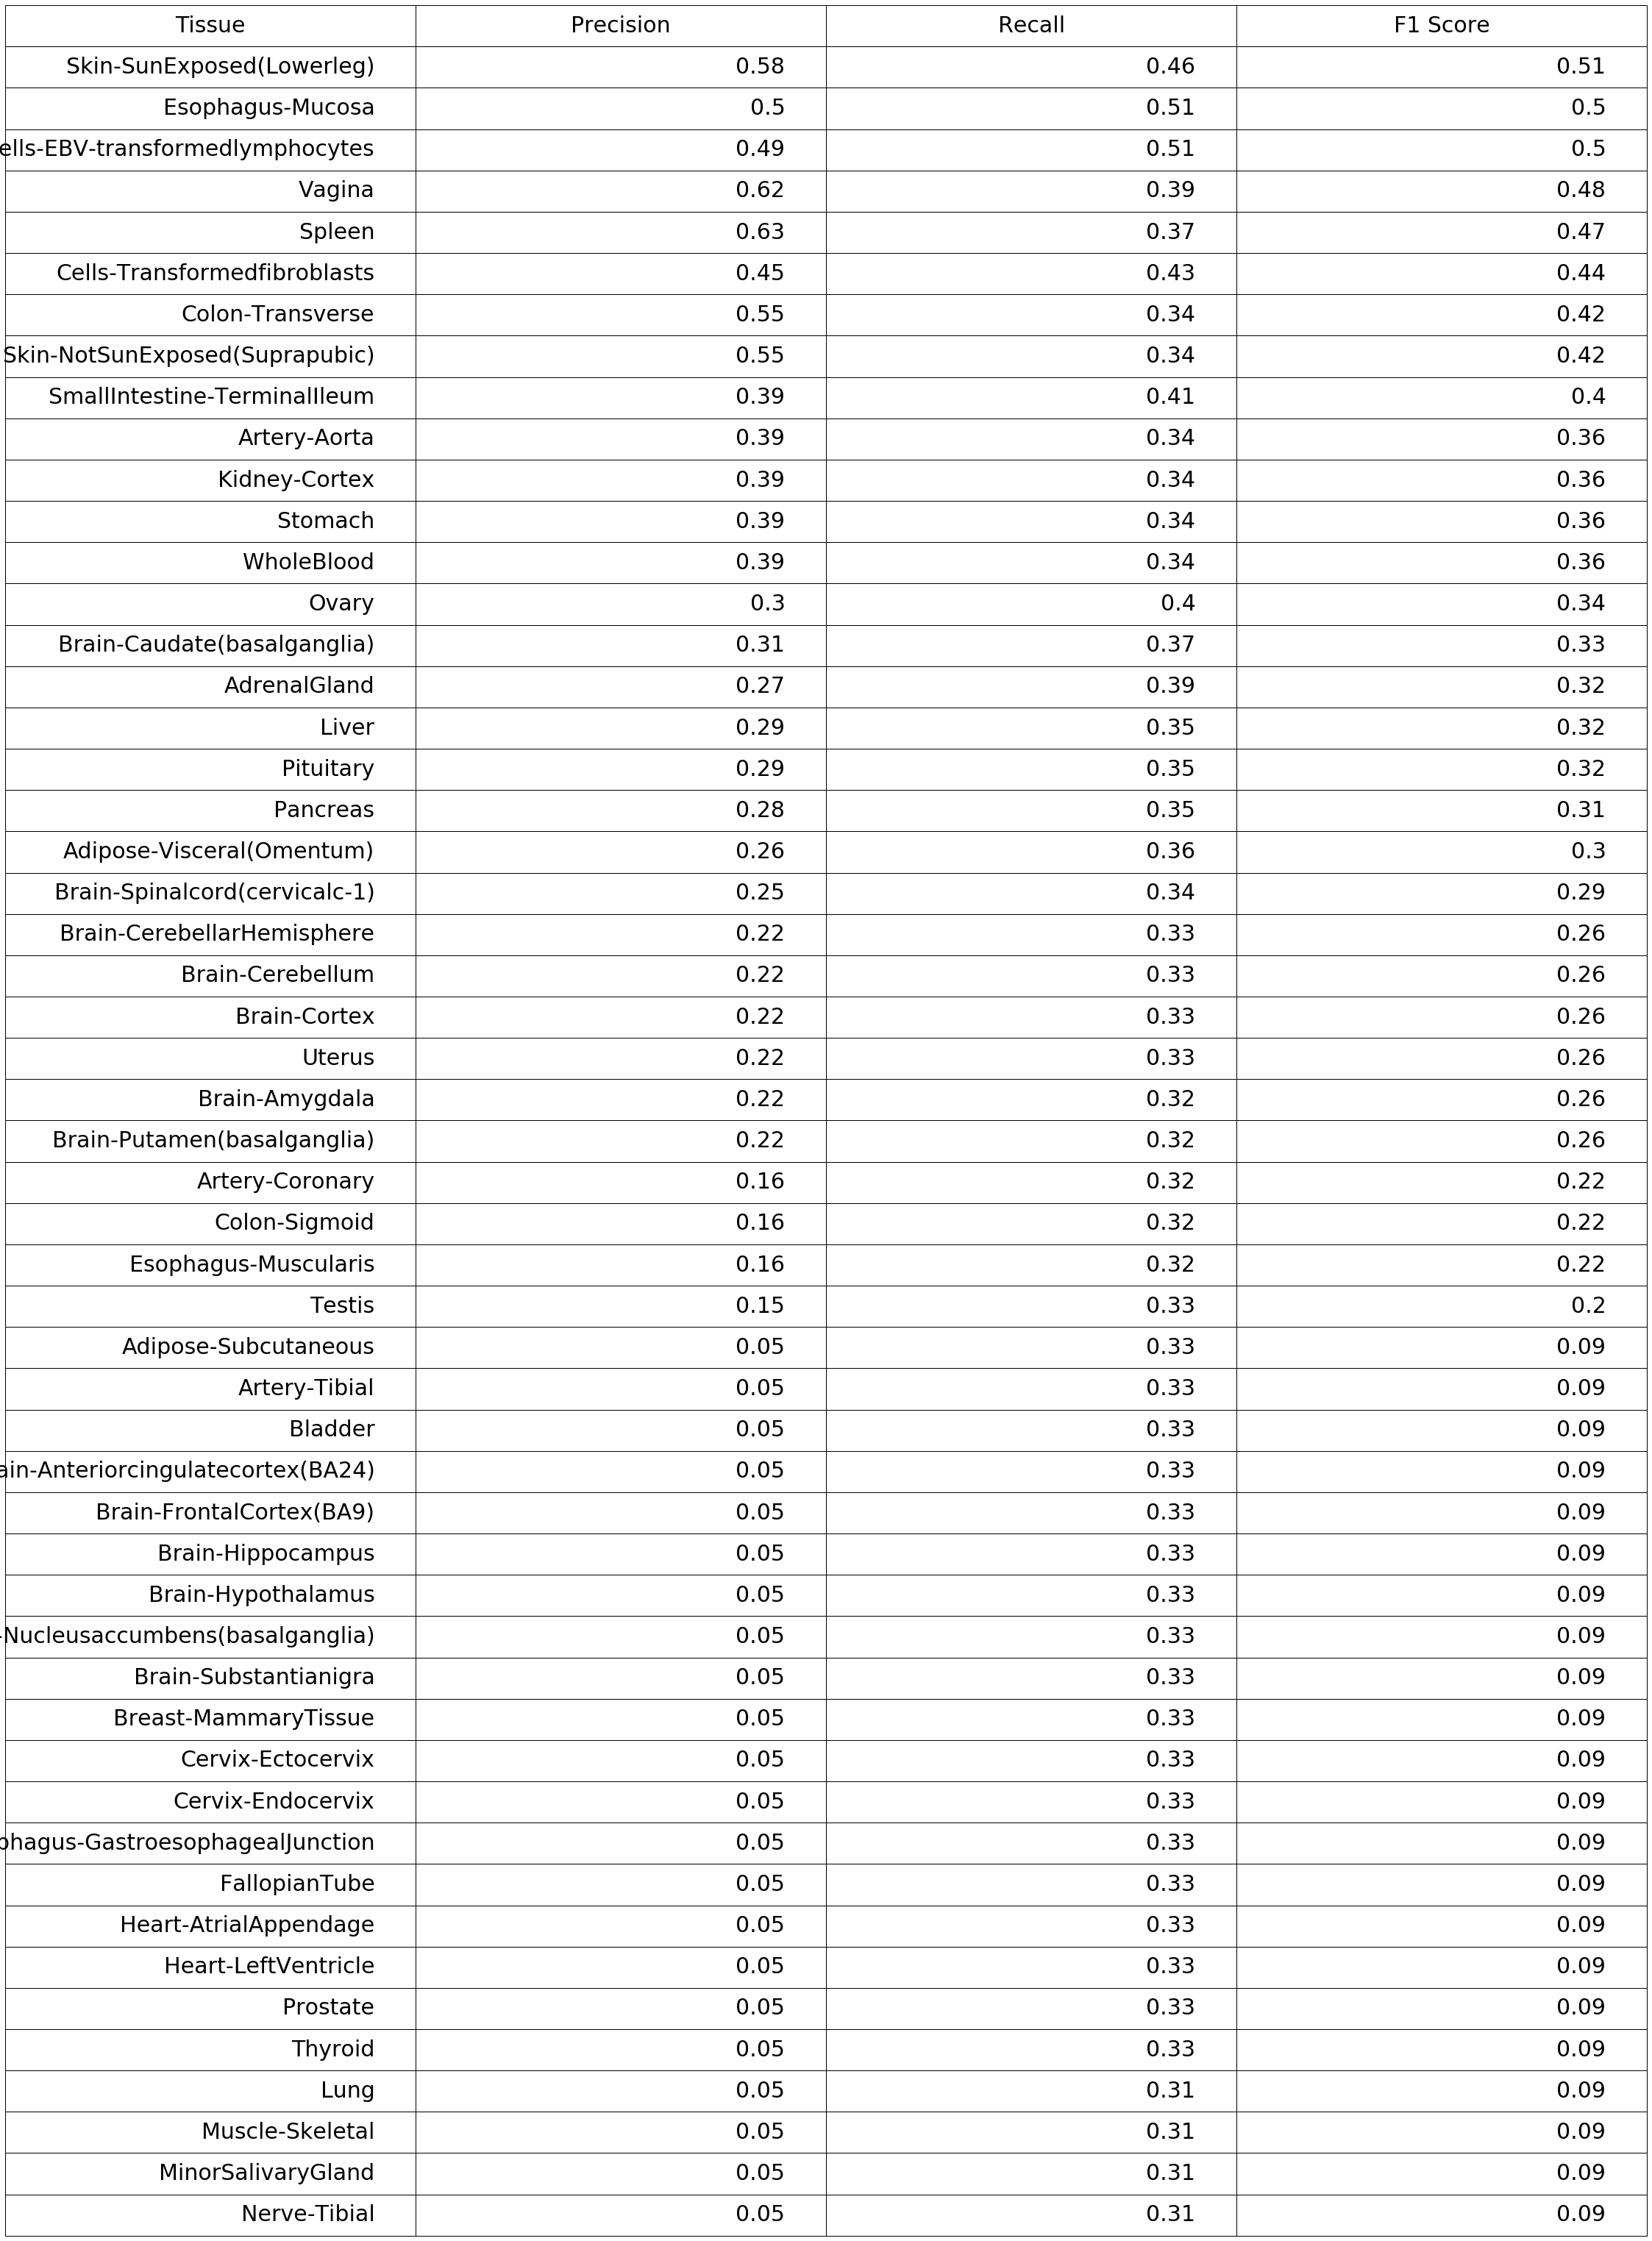

In [268]:
plt.figure(1, figsize=(20, 2))
plt.subplots_adjust(bottom = 0.1)
column_labels = ["Tissue", "Precision", "Recall", "F1 Score"]
ax = subplot(111, frame_on=False) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
the_table = ax.table(cellText=data, colLabels=column_labels, loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(30)
the_table.scale(2, 2)
table_props = the_table.properties()
table_cells = table_props['child_artists']
for cell in table_cells: cell.set_height(0.5)
plt.show()